# Sequence logos in matplotlib

Inspired by the discussion on https://github.com/biocore/scikit-bio/issues/805 and code by [Jeremy Widmann](https://github.com/biocore/scikit-bio/issues/805#issuecomment-73098553) where the letter patches were made from polygon vertices. Using paths instead of polygons allows for smoother patches.

### SVG path generation ###
- Font "Source Code Pro - Medium" TTF file obtained from https://fontlibrary.org.
- Letters were converted into SVG paths using https://github.com/donbright/font_to_svg, e.g.:

```
$ ./example1 ./fonts/source-code-pro-2.010R-ro-1.030R-it/TTF/SourceCodePro-Medium.ttf 65 > A.svg
```

### Reference ###

Sequence logos: https://schneider.ncifcrf.gov/logorecommendations.html

In [1]:
%matplotlib inline

In [2]:
from __future__ import division, print_function
from six import StringIO

from matplotlib.patches import PathPatch
from matplotlib.path import Path
from matplotlib import ticker
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas

from svgpath2mpl import parse_path

In [3]:
_pal = sns.color_palette('colorblind')
default_colors = {'A': _pal[1], 'C': _pal[0], 'G': _pal[4], 'T': _pal[2]}
default_glyphs = {}
default_glyphs['A'] = """\
M 235,-357
L 208,-267
L 389,-267
L 362,-357
Q 346,-411 330,-465
Q 314,-519 300,-575
L 296,-575
Q 282,-519 266,-465
Q 251,-411 235,-357
Z
M 26,0
L 242,-655
L 358,-655
L 574,0
L 468,0
L 412,-188
L 184,-188
L 128,0
L 26,0
Z
"""
default_glyphs['C'] = """\
M 352,12
Q 291,12 238,-10
Q 185,-33 146,-76
Q 107,-120 84,-182
Q 62,-245 62,-326
Q 62,-406 84,-469
Q 107,-532 146,-576
Q 186,-620 240,-643
Q 295,-667 360,-667
Q 420,-667 467,-642
Q 514,-618 544,-586
L 488,-523
Q 463,-549 432,-564
Q 401,-580 360,-580
Q 316,-580 280,-562
Q 244,-545 218,-512
Q 193,-480 179,-433
Q 165,-387 165,-329
Q 165,-270 179,-223
Q 193,-176 219,-143
Q 245,-110 281,-92
Q 317,-75 362,-75
Q 405,-75 439,-93
Q 473,-111 502,-144
L 558,-83
Q 519,-37 468,-12
Q 418,12 352,12
Z
"""
default_glyphs['G'] = """\
M 339,12
Q 277,12 224,-10
Q 171,-33 132,-76
Q 94,-120 72,-182
Q 51,-245 51,-326
Q 51,-406 73,-469
Q 95,-533 134,-577
Q 173,-621 227,-644
Q 281,-667 344,-667
Q 409,-667 454,-641
Q 499,-616 528,-586
L 472,-523
Q 449,-548 419,-564
Q 389,-580 344,-580
Q 302,-580 267,-562
Q 232,-545 207,-512
Q 182,-480 168,-433
Q 154,-387 154,-329
Q 154,-211 203,-143
Q 252,-75 345,-75
Q 375,-75 401,-84
Q 428,-93 445,-109
L 445,-265
L 324,-265
L 324,-347
L 537,-347
L 537,-65
Q 505,-33 453,-10
Q 402,12 339,12
Z
"""
default_glyphs['T'] = """\
M 250,0
L 250,-571
L 39,-571
L 39,-655
L 561,-655
L 561,-571
L 350,-571
L 350,0
L 250,0
Z
"""
default_glyphs['U'] = """\
M 301,12
Q 250,12 208,-3
Q 167,-18 137,-49
Q 107,-81 91,-130
Q 75,-180 75,-249
L 75,-655
L 176,-655
L 176,-243
Q 176,-153 210,-114
Q 245,-75 301,-75
Q 357,-75 392,-114
Q 428,-153 428,-243
L 428,-655
L 525,-655
L 525,-249
Q 525,-180 509,-130
Q 493,-81 464,-49
Q 435,-18 393,-3
Q 352,12 301,12
Z
"""

def _get_glyph(path_data, color, x, y, dx, dy, **kwargs):
    kwargs.setdefault('facecolor', color)
    kwargs.setdefault('edgecolor', 'none')
    path = parse_path(path_data)
    # normalize and flip upside down
    path.vertices[:, 0] -= path.vertices[:, 0].min()
    path.vertices[:, 1] -= path.vertices[:, 1].min()
    path.vertices[:, 0] /= path.vertices[:, 0].max()
    path.vertices[:, 1] /= path.vertices[:, 1].max()
    path.vertices[:, 1] = 1 - path.vertices[:, 1]
    # scale then translate
    path.vertices *= [dx, dy]
    path.vertices += [x, y]
    return PathPatch(path, **kwargs)

    
def _draw_logo(ax, matrix, charwidth, glyphs=default_glyphs, colors=default_colors):
    for i, (_, position) in enumerate(matrix.iterrows()):
        letters_sorted = position.sort_values()
        bottom = 0
        for letter, height in letters_sorted.iteritems():
            patch = _get_glyph(glyphs[letter], colors[letter],
                               i*charwidth, bottom, charwidth, height)
            ax.add_artist(patch)
            bottom += height


def plot_seqlogo(ax, pfm, info=False, charwidth=1.0, **kwargs):
    if info:
        info_content = 2 - pfm.apply(lambda p: (-p * np.log2(p)).sum(), axis=1)
        matrix = pfm.mul(info_content, axis=0)
    else:
        matrix = pfm
    
    seqlen = len(pfm)
    _draw_logo(ax, matrix, charwidth, **kwargs)
    ax.set_xlim([0, seqlen * charwidth])
    
    # major ticks
    ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(0, seqlen)))
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.tick_params(which='major', direction='out')
    # minor ticks
    ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0, seqlen) + 0.5))
    ax.xaxis.set_minor_formatter(ticker.FixedFormatter(np.arange(1, seqlen+1)))
    ax.tick_params(which='minor', length=0)
    
    if info:
        ax.set_ylim([0, 2])
        ax.yaxis.set_major_locator(ticker.FixedLocator([0., 1., 2.]))

### Example: CTCF core motif logo

In [4]:
ctcf_str = """\
P0 A C G T
P1 0.047246 0.003571 0.896649 0.052534
P2 0.065848 0.884012 0.004934 0.045206
P3 0.002425 0.990324 0.002480 0.004771
P4 0.570985 0.416802 0.006008 0.006205
P5 0.002533 0.468765 0.003265 0.525437
P6 0.002455 0.988463 0.004303 0.004779
P7 0.014711 0.016346 0.016151 0.952792
P8 0.327718 0.047936 0.551725 0.072621
P9 0.013941 0.352799 0.611807 0.021454
P10 0.068858 0.073635 0.002662 0.854844
P11 0.009063 0.002133 0.985576 0.003228
P12 0.026183 0.036267 0.821984 0.115566
P13 0.161310 0.448602 0.067884 0.322203
P14 0.207108 0.522929 0.144157 0.125805
P15 0.524443 0.052028 0.293162 0.130367
"""

def read_matrix(fp):
    return pandas.read_csv(fp, sep=' ', index_col=0)

def reverse_complement(matrix):
    col_order = ['A', 'C', 'G', 'T']
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
    return matrix.iloc[::-1].rename(columns=complement)[col_order]

pfm = read_matrix(StringIO(ctcf_str))
pfm.head()

,A,C,G,T
P0,,,,
P1,0.047246,0.003571,0.896649,0.052534
P2,0.065848,0.884012,0.004934,0.045206
P3,0.002425,0.990324,0.002480,0.004771
P4,0.570985,0.416802,0.006008,0.006205
P5,0.002533,0.468765,0.003265,0.525437


Text(0,0.5,'information content (bits)')

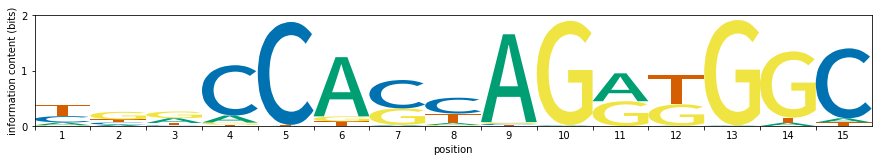

In [5]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
plot_seqlogo(ax, reverse_complement(pfm), info=True)
ax.set_aspect(1)
ax.set_xlabel('position')
ax.set_ylabel('information content (bits)')